In [16]:
!git clone https://github.com/dwgily/Deep-Learning.git

Cloning into 'Deep-Learning'...
remote: Enumerating objects: 13081, done.
remote: Counting objects: 100% (1284/1284), done.
remote: Compressing objects: 100% (621/621), done.
remote: Total 13081 (delta 659), reused 1281 (delta 658), pack-reused 11797 (from 1)
Receiving objects: 100% (13081/13081), 1.40 GiB | 17.46 MiB/s, done.
Resolving deltas: 100% (659/659), done.
Updating files: 100% (13055/13055), done.


# Imports

In [4]:
! pip install pycocotools
! pip install -U ffmpeg
! pip install torchmetrics

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=fc44a35bc89efbaff425d91c83bf67f59dc6d2645b58c79f6d83a5d0cbf502ef
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 43.4 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
import seaborn as sns
import copy
import torch
from torch.utils.data import Dataset,DataLoader,Subset
import torch.optim as optim
import torchvision
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
import torchvision.transforms.functional as tf
import albumentations as A
import pycocotools
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision

# Configuration

In [18]:
img_dir="/content/Deep-Learning/Pothole_Detection/Dataset/images"
annot_dir="/content/Deep-Learning/Pothole_Detection/Dataset/annotations"

#label 0 is fixed for background
classes=["background","pothole"]

num_classes=2
device="cuda" if torch.cuda.is_available() else "cpu"
batch_size=4
epochs=40
learning_rate=3e-5

model_weights_file="/content/Deep-Learning/Pothole_Detection/Dataset/model.pth"

threshold=0.25
iou_threshold=0.75

# Bounding Box Data Analysis

In [19]:
def parse_xml(annot_path):
    tree=ET.parse(annot_path)
    root=tree.getroot()

    width=int(root.find("size").find("width").text)
    height=int(root.find("size").find("height").text)
    boxes=[]

    for obj in root.findall("object"):
        bbox=obj.find("bndbox")
        xmin=int(bbox.find("xmin").text)
        ymin=int(bbox.find("ymin").text)
        xmax=int(bbox.find("xmax").text)
        ymax=int(bbox.find("ymax").text)

        boxes.append([xmin,ymin,xmax,ymax])

    return boxes,height,width

In [20]:
ignore_img=[]
for annot_name in os.listdir(annot_dir):
    img_name=annot_name[:-4]+".png"
    annot_path=os.path.join(annot_dir,annot_name)
    boxes,height,width=parse_xml(annot_path)

    for box in boxes:
        if box[0]<0 or box[0]>=box[2] or box[2]>width:
            print(box[0],box[2],width)
            print("x",annot_name)
            print("*"*50)
            ignore_img.append(img_name)
        elif box[1]<0 or box[1]>=box[3] or box[3]>height:
            print(box[1],box[3],height)
            print("y",file_name)
            print("*"*50)
            ignore_img.append(img_name)

273 273 400
x potholes58.xml
**************************************************
312 401 400
x potholes214.xml
**************************************************


# Data Augmentation

In [21]:
train_transform=A.Compose([A.HorizontalFlip(),
                           A.ShiftScaleRotate(rotate_limit=15,value=0,
                                              border_mode=cv2.BORDER_CONSTANT),

                           A.OneOf(
                                   [A.CLAHE(),
                                    A.RandomBrightnessContrast(),
                                    A.HueSaturationValue()],p=1),
                           A.GaussNoise(),
                           A.RandomResizedCrop(height=480,width=480)],
                          bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15,
                                                   label_fields=["labels"]))

val_transform=A.Compose([A.Resize(height=480,width=480)],
                        bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15,
                                                 label_fields=["labels"]))

# Custom Dataset

In [22]:
class PotholeDetection(Dataset):
    def __init__(self,img_dir,annot_dir,transform=None):
        super().__init__()
        self.img_dir=img_dir
        self.annot_dir=annot_dir
        self.img_list=sorted([img for img in os.listdir(self.img_dir)
                              if img not in ignore_img])
        self.transform=transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self,idx):
        img_name=self.img_list[idx]
        img_path=os.path.join(self.img_dir,img_name)
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        annot_name=img_name[:-4]+".xml"
        annot_path=os.path.join(self.annot_dir,annot_name)
        boxes,height,width=parse_xml(annot_path)
        labels=[1]*len(boxes)

        if self.transform is not None:
            transformed=self.transform(image=img,bboxes=boxes,labels=labels)
            img=transformed["image"]
            boxes=transformed["bboxes"]
            labels=transformed["labels"]

        if len(np.array(boxes).shape)!=2 or np.array(boxes).shape[-1]!=4:
            boxes=[[0.0,0.0,1.0,1.0]]
            labels=[0]

        img=img/255
        img=tf.to_tensor(img)
        img=img.to(dtype=torch.float32)
        target={}
        target["boxes"]=torch.tensor(boxes,dtype=torch.float32)
        target["labels"]=torch.tensor(labels,dtype=torch.int64)
        target["id"]=torch.tensor(idx)

        return img,target

In [23]:
train_ds=PotholeDetection(img_dir,annot_dir,train_transform)
val_ds=PotholeDetection(img_dir,annot_dir,val_transform)

In [24]:
from torch.utils.data import Subset

In [25]:
idxs=list(range(len(train_ds)))

np.random.shuffle(idxs)
train_idx=idxs[:int(0.85*len(train_ds))]
val_idx=idxs[int(0.85*len(train_ds)):]

train_ds=Subset(train_ds,train_idx)
val_ds=Subset(val_ds,val_idx)

# Data Visualization

In [26]:
def show_bbox(img,target,color=(0,255,0)):
    img=np.transpose(img.cpu().numpy(),(1,2,0))
    boxes=target["boxes"].cpu().numpy().astype("int")
    labels=target["labels"].cpu().numpy()
    img=img.copy()
    for i,box in enumerate(boxes):
        idx=int(labels[i])
        text=classes[idx]

        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,text,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

    return img

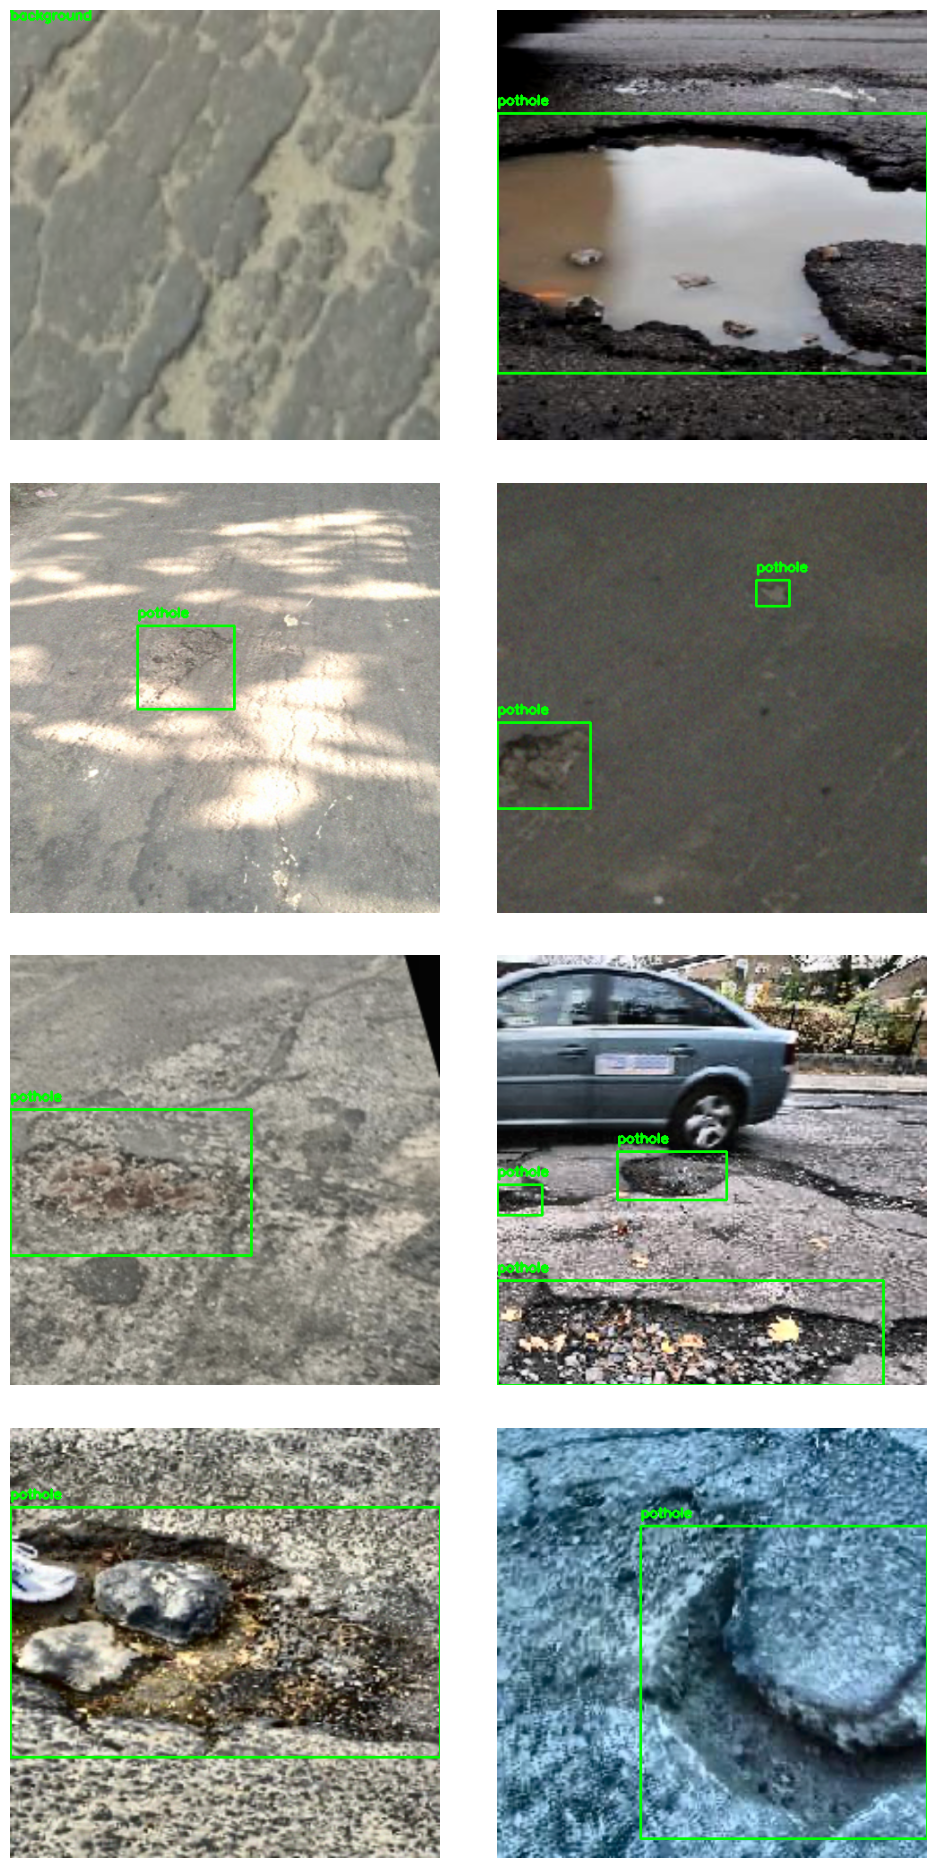

In [27]:
fig,axes=plt.subplots(4,2,figsize=(12,24))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

idxs=np.random.choice(range(len(train_ds)),8)
for i,idx in enumerate(idxs):
    img,target=train_ds[idx]
    output_img=show_bbox(img,target)
    ax[i].imshow(output_img)
    ax[i].axis("off")

# DataLoader

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    collate_fn=collate_fn,
                    pin_memory=True if device=="cuda" else False)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                  collate_fn=collate_fn,
                  pin_memory=True if device=="cuda" else False)

In [ ]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [ ]:
for params in model.backbone.features.parameters():
    params.requires_grad=False

parameters=[params for params in model.parameters() if params.requires_grad]

optimizer=optim.Adam(parameters,lr=learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                  patience=7, threshold=0.0001)

NameError: name 'model' is not defined

# Training

In [ ]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

# Evaluation

In [ ]:
def preprocess_bbox(prediction):

    """Non-max suppression is the final step of these object detection algorithms and is
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""

    processed_bbox={}

    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=iou_threshold)

    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]

    return processed_bbox

In [ ]:
metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
metric.to(device)

model.eval()
with torch.no_grad():
    for imgs,targets in val_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        predictions=model(imgs)

        results=[]
        for prediction in predictions:
            results.append(preprocess_bbox(prediction))

        metric.update(results,targets)

results=metric.compute()

In [ ]:
mean_ap=results["map"].item()
mean_ap_50=results["map_50"].item()
mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {mean_ap_75:.4f}")

# Inference

In [ ]:
"""During inference, the model requires only the input tensors, and returns the
   post-processed predictions as a List[Dict[Tensor]], one for each input image. The fields
   of the Dict are as follows:
   - boxes (FloatTensor[N, 4]): the predicted boxes in [x0, y0, x1, y1] format
   - labels (Int64Tensor[N]): the predicted labels for each image
   - scores (Tensor[N]): the scores or each prediction"""

fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

imgs,targets=next(iter(val_dl))
model.eval()
with torch.no_grad():
    output=model([img.to(device) for img in imgs])

for i,idx in enumerate(range(len(imgs))):
    img=imgs[idx]
    prediction=output[idx]

    #real bounding boxes
    output_img=show_bbox(img,targets[idx],color=(0,255,0));
    axes[i,0].imshow(output_img);
    axes[i,0].axis("off");

    #predicted bounding box
    predict=preprocess_bbox(prediction)
    output_img=show_bbox(img,predict,color=(255,0,0));
    axes[i,1].imshow(output_img);
    axes[i,1].axis("off");

plt.savefig("4.png")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
import seaborn as sns
import copy
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
import torchvision
import albumentations as A
import pycocotools
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision
from torchvision.transforms import transforms
from torchvision.models.detection import ssd300_vgg16
from torchvision.models.detection.ssd import SSDHead, det_utils
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode


In [ ]:
from torchvision import transforms

In [ ]:
img_transform = transforms.ToTensor()

In [ ]:
import cv2
import numpy as np
import torch
import torchvision
from torchvision.models.detection import ssd300_vgg16
from torchvision.models.detection.ssd import SSDHead
from torchvision.models.detection import _utils as det_utils
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # Assuming you have 2 classes (background and pothole)

In [ ]:
import cv2
import numpy as np
import torch
import torchvision
from torchvision.models.detection import ssd300_vgg16
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from base64 import b64decode

def capture_image_function():

    # Load the trained SSD model
    model_weights_pth="/content/Deep-Learning/Pothole_Detection/Dataset/model.pth"
    model=ssd300_vgg16()
    in_channels=det_utils.retrieve_out_channels(model.backbone,(480,480))
    num_anchors=model.anchor_generator.num_anchors_per_location()
    model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                    num_classes=num_classes)
    model.load_state_dict(torch.load(model_weights_pth,map_location=device))
    model.to(device)
    model.eval()



    # Define classes
    classes = {1: 'Pothole'}

    # Function to preprocess the image for inference
    def preprocess_image(img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (300, 300))
        img = img / 255.0
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
        img = img.unsqueeze(0).to(device)  # Move tensor to device
        return img

    # Function to preprocess the bounding box predictions
    def preprocess_bbox(prediction, threshold=0.5, iou_threshold=0.5):
        processed_bbox = {}

        boxes = prediction["boxes"][prediction["scores"] >= threshold]
        scores = prediction["scores"][prediction["scores"] >= threshold]
        labels = prediction["labels"][prediction["scores"] >= threshold]

        nms_indices = torchvision.ops.nms(boxes, scores, iou_threshold)

        processed_bbox["boxes"] = boxes[nms_indices]
        processed_bbox["scores"] = scores[nms_indices]
        processed_bbox["labels"] = labels[nms_indices]

        return processed_bbox

    # Function to draw bounding boxes on the image
    def show_bbox(img, target, color=(0, 255, 0)):
        img = img.copy()
        boxes = target["boxes"].cpu().numpy().astype("int")
        labels = target["labels"].cpu().numpy()

        for i, box in enumerate(boxes):
            idx = int(labels[i])
            text = classes[idx]

            # Scale the bounding box coordinates to the original image size
            x1, y1, x2, y2 = box
            x1 = int(x1 * img.shape[1] / 300)
            y1 = int(y1 * img.shape[0] / 300)
            x2 = int(x2 * img.shape[1] / 300)
            y2 = int(y2 * img.shape[0] / 300)

            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            y = y1 - 10 if y1 - 10 > 10 else y1 + 10
            cv2.putText(img, text, (x1, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        return img

    # Function to capture photo using webcam in Google Colab
    def take_photo(filename='photo.jpg', quality=0.8):
        js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
        display(js)
        data = eval_js('takePhoto({})'.format(quality))
        binary = b64decode(data.split(',')[1])
        with open(filename, 'wb') as f:
            f.write(binary)
        return filename

    try:
        # Capture photo
        filename = take_photo()
        print('Saved to {}'.format(filename))

        # Load the captured image
        frame = cv2.imread(filename)

        # Preprocess the frame for inference
        input_img = preprocess_image(frame)

        # Inference
        with torch.no_grad():
            predictions = model(input_img)[0]  # Assuming only one prediction

        # Process predictions
        processed_boxes = preprocess_bbox(predictions)

        # Show bounding boxes on the image
        output_img = show_bbox(frame, processed_boxes)

        # Display the image with bounding boxes
        cv2_imshow(output_img)

    except Exception as err:
        # Handle exceptions
        print(str(err))


<IPython.core.display.Javascript object>

Saved to photo.jpg


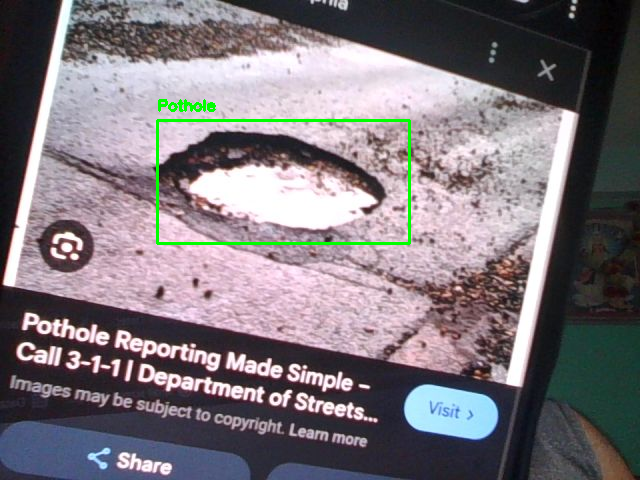

In [ ]:
capture_image_function()

# Video Inference

In [ ]:
# video_path="/kaggle/input/potholes-detection-inference-on-videos/pothole.mp4"
# video_out_path="/kaggle/working/output_video.mp4"

# cap=cv2.VideoCapture(video_path)
# if (cap.isOpened() == False):
#     print('Error while trying to read video. Please check path again')

# # define codec and create VideoWriter object
# out=cv2.VideoWriter(video_out_path,
#                     cv2.VideoWriter_fourcc(*'XVID'), 30,
#                     (480,480))

# model=model.eval()

# # read until end of video
# while(cap.isOpened()):
#     # capture each frame of the video
#     ret, frame=cap.read()
#     if ret==True:
#         with torch.no_grad():
#             # get predictions for the current frame
#             frame=cv2.resize(frame,(480,480))
#             frame=frame/255
#             frame=np.transpose(frame,(2,0,1))
#             frame=torch.as_tensor(frame,dtype=torch.float32)
#             frame=frame.to(device)
#             output=model([frame])
#             predict=preprocess_bbox(output[0])
#             output_img=show_bbox(frame,predict)
#             output_img=(output_img*255).astype(np.uint8)
#             out.write(output_img)
#     else:
#         break

# # release VideoCapture()
# out.release()
# cap.release()

Code for the Video Processing